In [1]:
%load_ext autoreload
%autoreload 1

from pathlib import Path

import numpy as np
import safetensors
from sklearn.decomposition import PCA

from matplotlib import pyplot as plt

from prelib import data_dir
%aimport e6db.utils.numpy
from e6db.utils.numpy import load_tags

In [2]:
with safetensors.safe_open(data_dir / 'implicit_tag_factors.safetensors', framework='numpy') as st:
    X0 = st.get_tensor('tag_factors')

tags2id, tags, tag_categories = load_tags(data_dir)

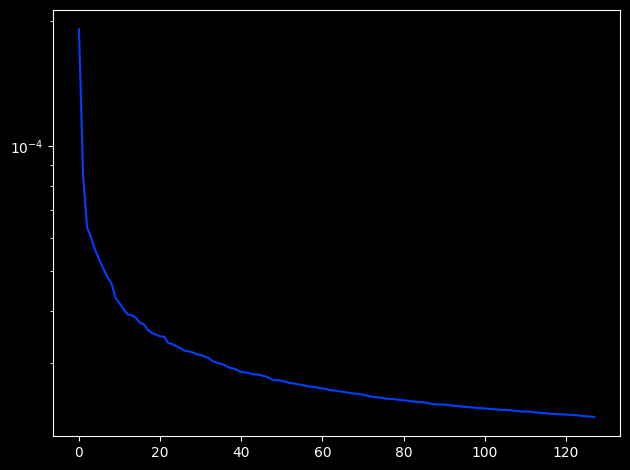

In [3]:
X = X0.copy()
# You might want to play with normalization, ie disabling these:
#X /= np.linalg.norm(X, axis=1)[:, None]

# A first rank truncation using PCA helps smooth the noise
pca = PCA(128)
Xt = pca.fit_transform(X)
Xt /= np.linalg.norm(Xt, axis=1)[:, None] # <- same here

plt.semilogy(pca.explained_variance_)

In [4]:
Xt = X0.copy()
Xt /= np.linalg.norm(Xt, axis=1)[:, None]

In [5]:
#sel_tags = ['bodily_fluids', 'genital_fluids', 'cum', 'precum', 'sweat', 'urine', 'tears', 'tears', 'blood']
sel_tags = ['trio', 'trio_focus', 'duo', 'duo_focus', 'solo', 'solo_focus', 'threesome', 'foursome', 'fivesome']

sel_idxs = [tags2id[t] for t in sel_tags if t in tags2id]
sel_idxs.sort()
sel_tags = [tags[i] for i in sel_idxs]
print(' '.join(sel_tags))

# Select neighboring tags similar to the input tags
n_neighbors = 64
n_neighbors_display = 32
top_k = int(1.5 * n_neighbors / len(sel_idxs))

scores = Xt @ Xt[sel_idxs].T
scores[sel_idxs, :] = float('-inf')
neigh_idxs = np.unique(np.argpartition(-scores, top_k, axis=0)[:top_k])
if len(neigh_idxs) > n_neighbors:
    neigh_idxs = neigh_idxs[np.argpartition(-scores[neigh_idxs, :].sum(axis=1), n_neighbors)[:n_neighbors]]

solo duo solo_focus trio threesome duo_focus foursome trio_focus fivesome


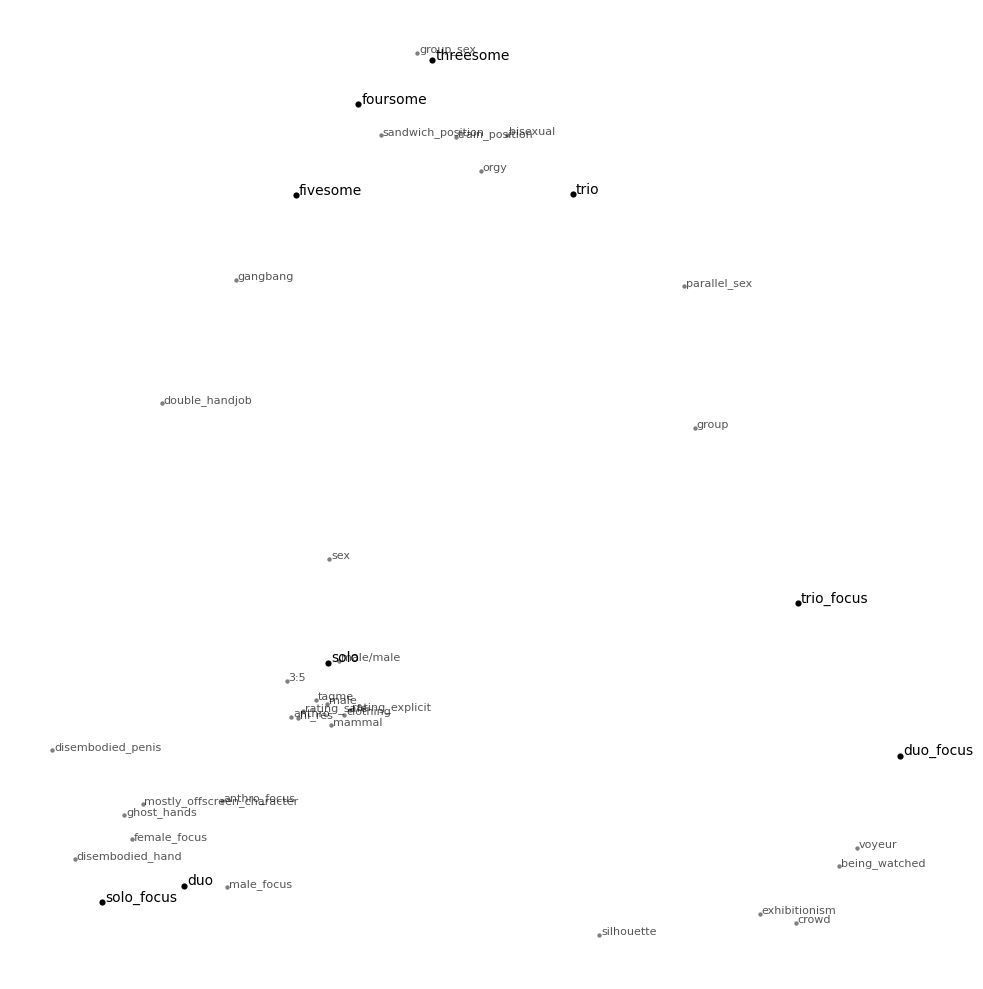

In [6]:
idxs = np.concatenate([sel_idxs, neigh_idxs])

# Local PCA
X2 = Xt[idxs].copy()
X2 /= np.linalg.norm(X2, axis=1)[:, None]
X2 -= X2.mean(0)
X2 /= np.linalg.norm(X2, axis=1)[:, None]
X2t = PCA(2).fit_transform(X2)[:,::-1]

dark_mode = False
fg_color = 'white' if dark_mode else 'black'
bg_color = 'black' if dark_mode else 'white'

f, ax = plt.subplots(figsize=(10,10))
ax.axis('off')
f.set_facecolor(bg_color)

dx = 0.01
ax.scatter(*X2t[:len(sel_idxs)].T, 
           c=fg_color, linewidth=0, s=20)
for i, t in enumerate(sel_tags):
    ax.annotate(t, tuple(X2t[i,:] + [dx*0.5, dx*0.25]), 
                color=fg_color)

ax.scatter(*X2t[len(sel_idxs):len(sel_idxs) + n_neighbors_display].T, 
           c=fg_color, linewidth=0, s=10, alpha=0.5)
for i, t in enumerate(tags[neigh_idxs[:n_neighbors_display]], len(sel_idxs)):
    ax.annotate(t, tuple(X2t[i,:] + [dx*0.3, dx*0.3/2]), 
                color=fg_color, fontsize=8, alpha=2/3)

f.tight_layout()